In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [5]:
pip install tensorflow==2.10

  Using cached tensorflow-2.10.0-cp38-cp38-win_amd64.whl.metadata (3.1 kB)
Using cached tensorflow-2.10.0-cp38-cp38-win_amd64.whl (455.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_data = "D:\data science\Brain_tumor classifiaction\tumor_Training"
test_data = "D:\data science\Brain_tumor classifiaction\tumor_Testing"

In [3]:
import os

# Count images in training and testing directories
def count_images(data_path):
    total_images = 0
    print(f"Counting images in: {data_path}")
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            total_images += num_images
            print(f"{class_name}: {num_images} images")
    print(f"Total: {total_images} images\n")
    return total_images

# Count training and testing images
train_total = count_images(r"D:\data science\Brain_tumor classifiaction\tumor_Training")
test_total = count_images(r"D:\data science\Brain_tumor classifiaction\tumor_Testing")

Counting images in: D:\data science\Brain_tumor classifiaction\tumor_Training
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images
Total: 5712 images

Counting images in: D:\data science\Brain_tumor classifiaction\tumor_Testing
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images
Total: 1311 images



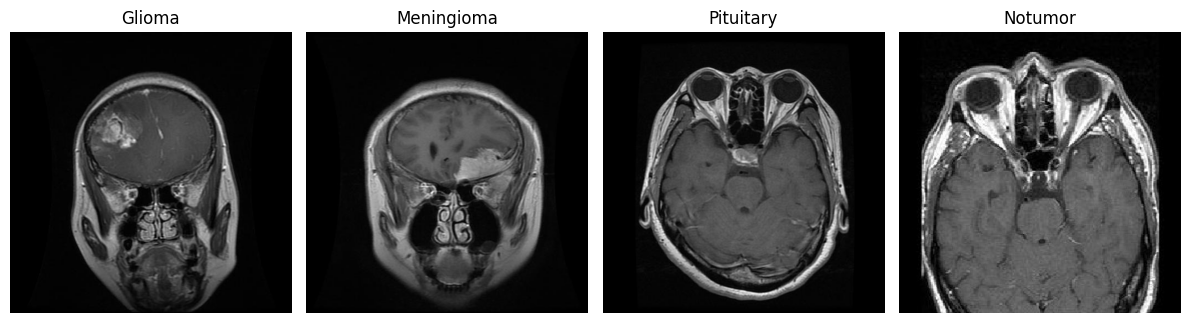

In [1]:
# class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# # Plot sample images from each class
# plt.figure(figsize=(12, 6))
# for i, class_name in enumerate(class_names):
#     class_path = os.path.join(train_data, class_name)
#     img_name = os.listdir(class_path)[0]  # Pick the first image in the folder
#     img_path = os.path.join(class_path, img_name)
#     img = Image.open(img_path)

#     plt.subplot(1, 4, i+1)
#     plt.imshow(img, cmap='gray')
#     plt.title(class_name.replace('_', ' ').title())
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

import os
import matplotlib.pyplot as plt
from PIL import Image

train_data = r"D:\data science\Brain_tumor classifiaction\tumor_Training"

class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Plot sample images from each class
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_data, class_name)
    # Filter image files only
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    if not image_files:
        continue
    img_name = image_files[0]  # Pick the first image in the folder
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)

    plt.subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_name.replace('_', ' ').title())
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
 # Define image size and batch size (also added training Parameters later)
image_size = (128, 128)
batch_size = 32
num_classes = 4
input_shape = (128, 128, 3)
epochs = 60
learning_rate = 0.001

In [30]:
# Data Augmentation & Preprocessing for Training
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.15,
#     zoom_range=0.15,
#     horizontal_flip=True,
#     validation_split=0.2,
#     rotation_range=15,
#     fill_mode='nearest',
# )

# enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2,
)


In [7]:
# Create training dataset
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42 
)

Found 4571 images belonging to 4 classes.


In [8]:
# Create validation dataset (without data augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle= False,
    seed= 42
)

Found 1141 images belonging to 4 classes.


Let's use Transfer learning model to train them 

In [9]:
num_classes = 4
input_shape = (128, 128, 3)
epoch = 60
lr = 0.001

In [10]:
# Model
def createModel(base_model):

    # Add layer
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
def evaluate(model):
    y_pred = model.predict(validation_generator).argmax(axis = 1)
    y_true = validation_generator.classes

    class_labels = list(validation_generator.class_indices.keys())

    conf_mat = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    display(HTML('<hr>'))

    # Classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

In [12]:
def historyPlot(history):
    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# Implement early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

In [14]:
def trainModel(model):
    
    # Create and compile the model
    model = createModel(model)
    model.summary()
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=epoch,
        validation_data=validation_generator,
        callbacks = callbacks,
        verbose = 0
    )

    return model, history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                65600     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                      

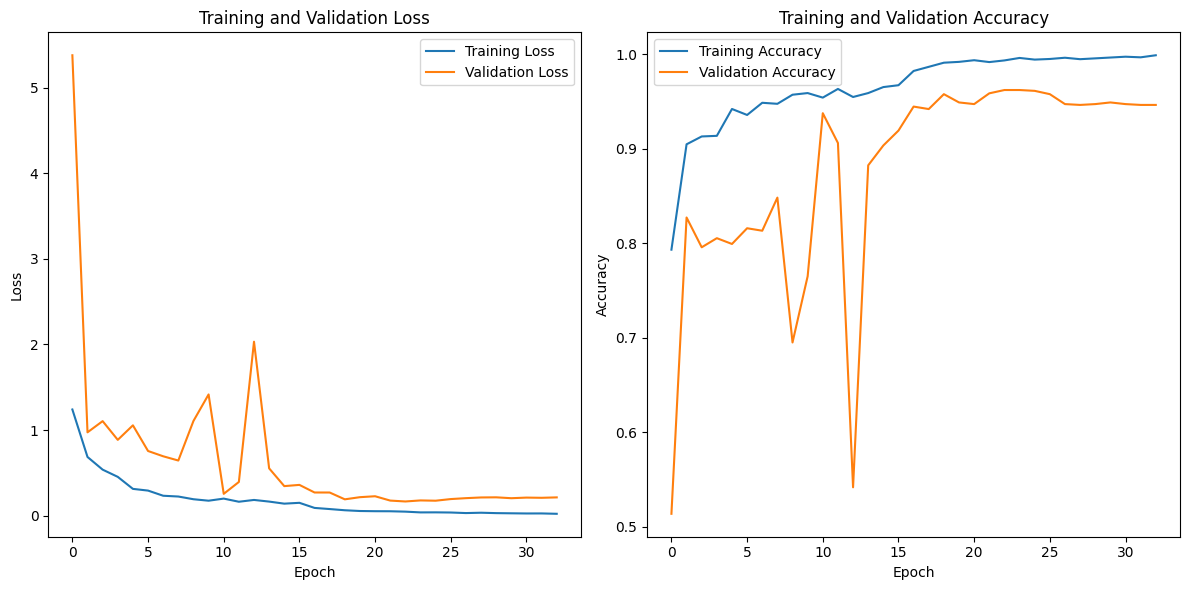

36/36 [==============================] - 3s 50ms/step


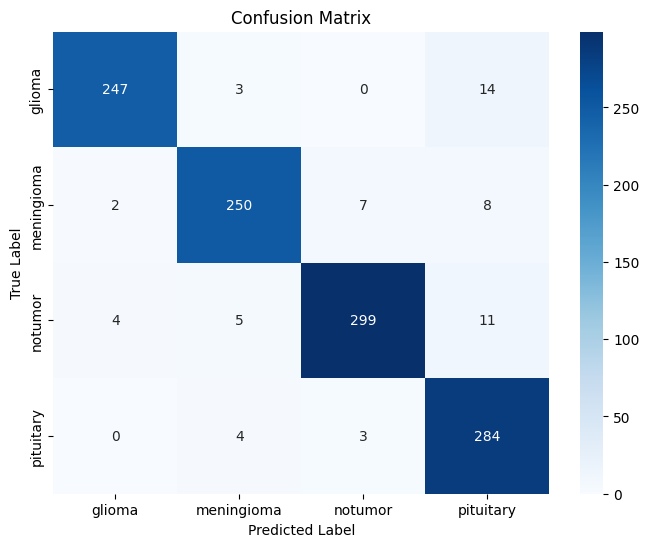

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       264
  meningioma       0.95      0.94      0.95       267
     notumor       0.97      0.94      0.95       319
   pituitary       0.90      0.98      0.93       291

    accuracy                           0.95      1141
   macro avg       0.95      0.95      0.95      1141
weighted avg       0.95      0.95      0.95      1141



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                131136    
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                      

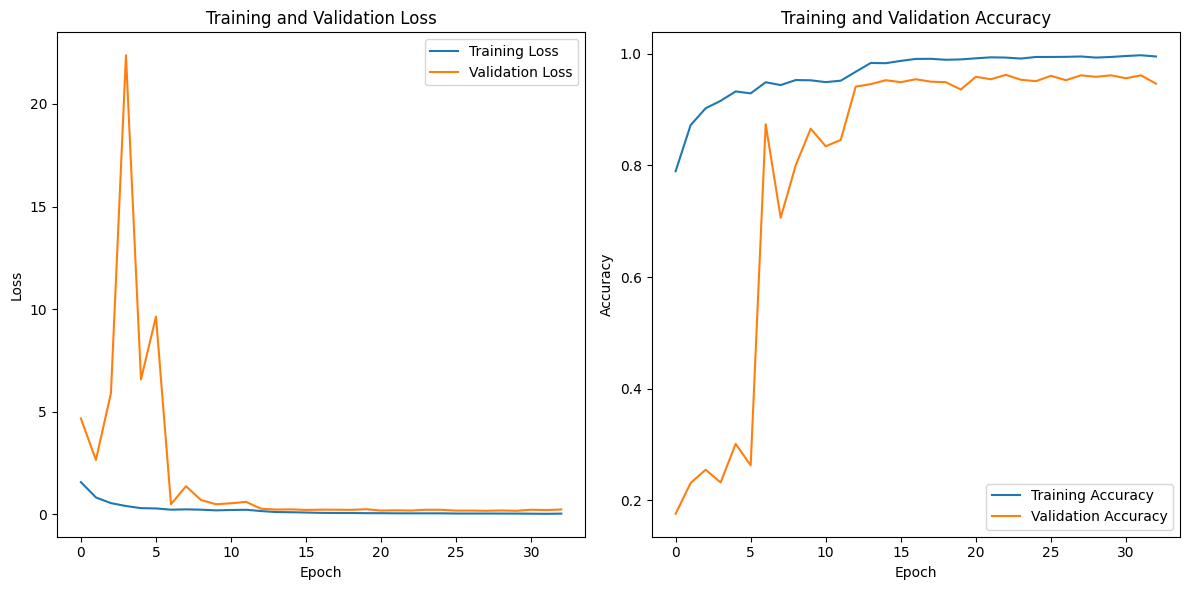

36/36 [==============================] - 2s 41ms/step


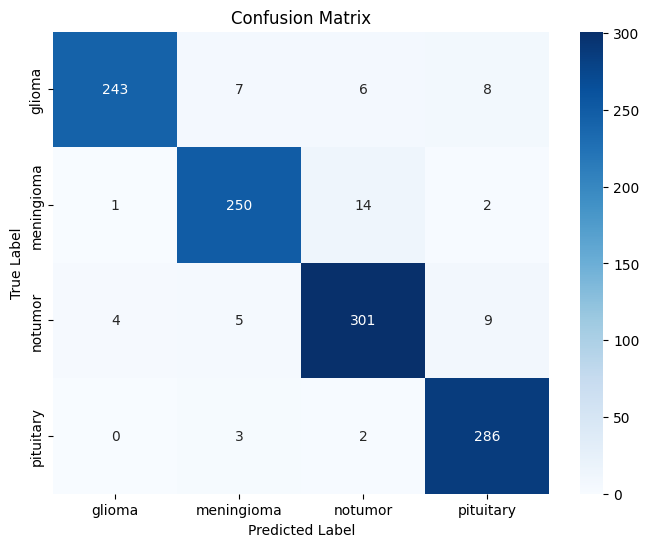

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       264
  meningioma       0.94      0.94      0.94       267
     notumor       0.93      0.94      0.94       319
   pituitary       0.94      0.98      0.96       291

    accuracy                           0.95      1141
   macro avg       0.95      0.95      0.95      1141
weighted avg       0.95      0.95      0.95      1141



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                      

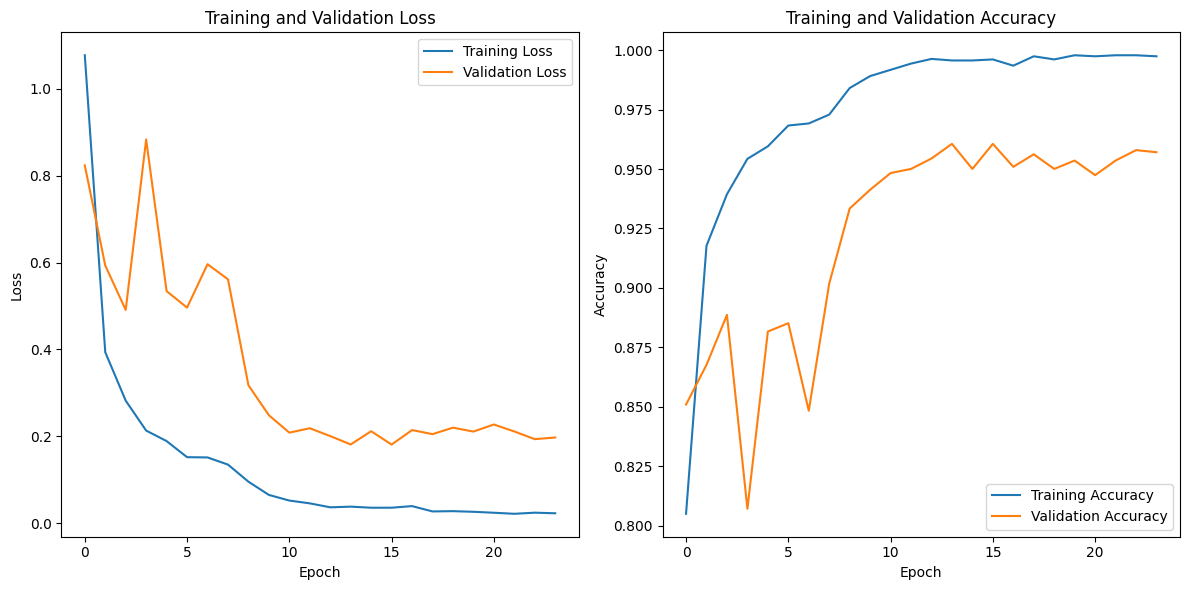

36/36 [==============================] - 2s 39ms/step


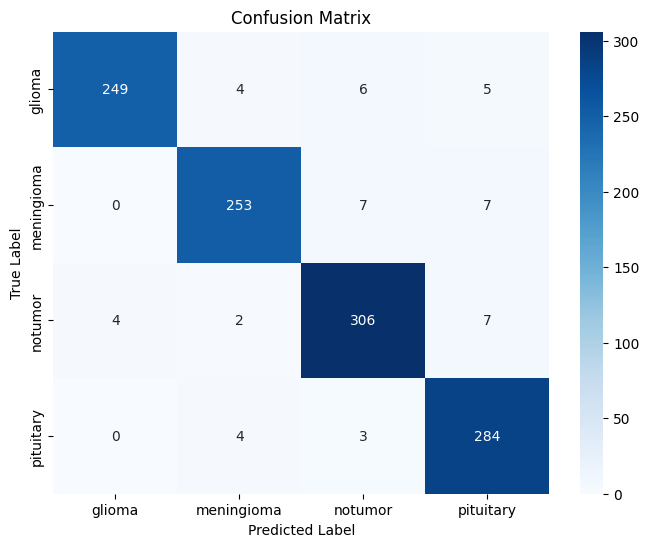

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.94      0.96       264
  meningioma       0.96      0.95      0.95       267
     notumor       0.95      0.96      0.95       319
   pituitary       0.94      0.98      0.96       291

    accuracy                           0.96      1141
   macro avg       0.96      0.96      0.96      1141
weighted avg       0.96      0.96      0.96      1141



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                65600     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                

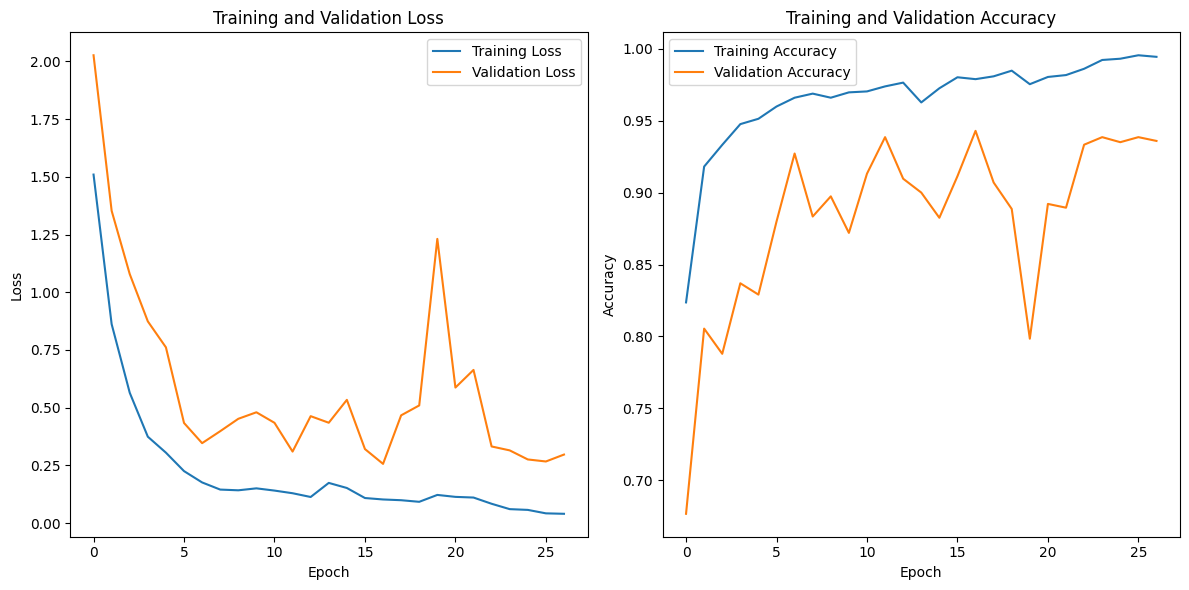

36/36 [==============================] - 2s 41ms/step


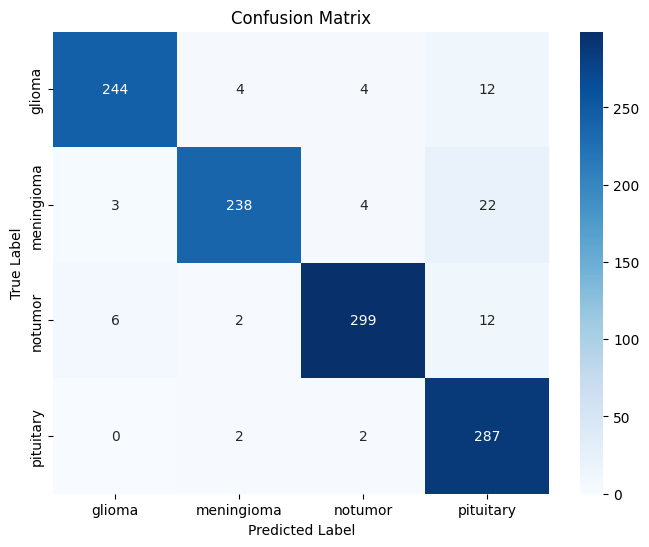

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       264
  meningioma       0.97      0.89      0.93       267
     notumor       0.97      0.94      0.95       319
   pituitary       0.86      0.99      0.92       291

    accuracy                           0.94      1141
   macro avg       0.94      0.93      0.94      1141
weighted avg       0.94      0.94      0.94      1141



In [23]:
from tensorflow.keras.applications import DenseNet121, ResNet50, Xception, MobileNet

trained_models = []

# Define base models
models_to_train = [
    ('DenseNet121', DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('ResNet50', ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('Xception', Xception(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('MobileNet', MobileNet(weights='imagenet', include_top=False, input_shape=input_shape))
]

# Train the models
for name, base_model in models_to_train:
    display(HTML(f'<h2>{name}</h2>'))
    display(HTML('<hr>'))
    model, history = trainModel(base_model)
    # Save the trained model
    model.save(f'{name}_trained_model.h5')
    display(HTML('<hr>'))
    historyPlot(history)
    display(HTML('<hr>'))
    evaluate(model)
    display(HTML('<hr>'))
    # Store the trained model and name
    trained_models.append((name, model))

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_data = r"D:\\data science\\Brain_tumor classifiaction\\tumor_Testing"
image_size = (224, 224)  # example target size, adjust as needed

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 1311 images belonging to 4 classes.


In [25]:
def evaluate_on_test(model, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)

    class_labels = list(test_generator.class_indices.keys())

    conf_mat = confusion_matrix(y_true, y_pred)

    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML('<hr>'))

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    display(HTML('<hr>'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    display(HTML('<hr>'))
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

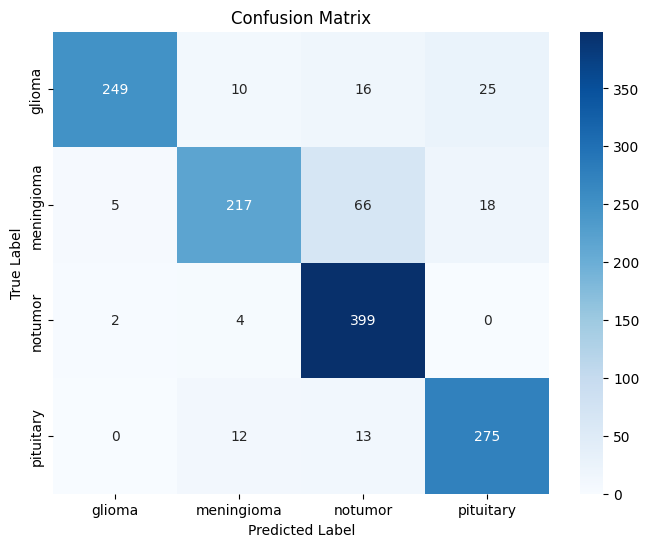

Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.83      0.90       300
  meningioma       0.89      0.71      0.79       306
     notumor       0.81      0.99      0.89       405
   pituitary       0.86      0.92      0.89       300

    accuracy                           0.87      1311
   macro avg       0.88      0.86      0.87      1311
weighted avg       0.88      0.87      0.87      1311



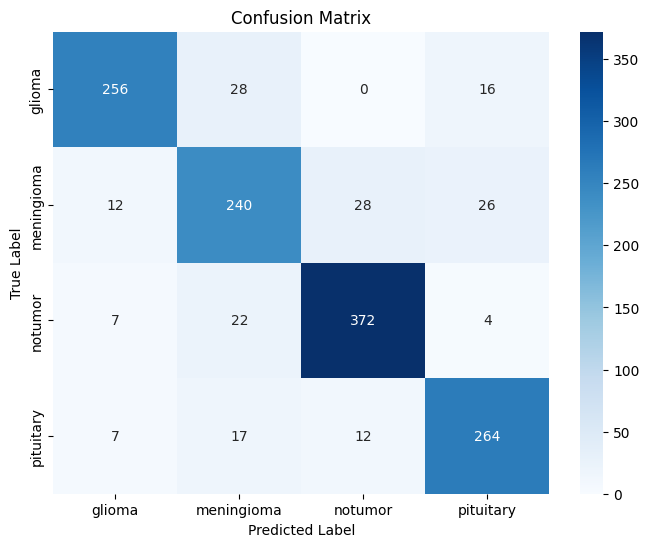

Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.85      0.88       300
  meningioma       0.78      0.78      0.78       306
     notumor       0.90      0.92      0.91       405
   pituitary       0.85      0.88      0.87       300

    accuracy                           0.86      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.86      0.86      0.86      1311



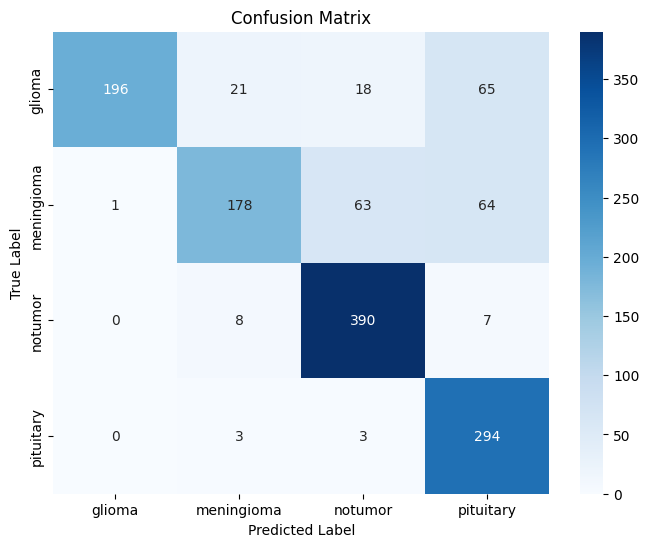

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.65      0.79       300
  meningioma       0.85      0.58      0.69       306
     notumor       0.82      0.96      0.89       405
   pituitary       0.68      0.98      0.81       300

    accuracy                           0.81      1311
   macro avg       0.84      0.79      0.79      1311
weighted avg       0.84      0.81      0.80      1311



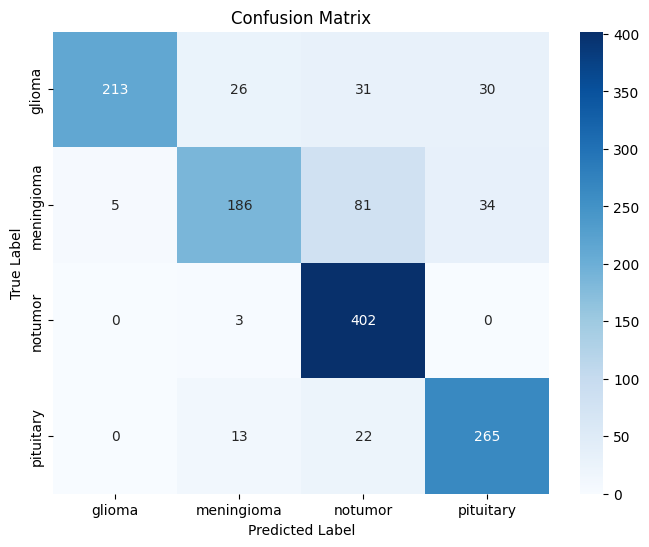

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.71      0.82       300
  meningioma       0.82      0.61      0.70       306
     notumor       0.75      0.99      0.85       405
   pituitary       0.81      0.88      0.84       300

    accuracy                           0.81      1311
   macro avg       0.84      0.80      0.80      1311
weighted avg       0.83      0.81      0.81      1311



,Model,Accuracy,Precision,Recall,F1 Score
0,DenseNet121,0.869565,0.878418,0.869565,0.867350
1,ResNet50,0.863463,0.864014,0.863463,0.863471
2,Xception,0.807018,0.836150,0.807018,0.799974
3,MobileNet,0.813120,0.830009,0.813120,0.807555


In [26]:
results = []

for name, model in trained_models:
    result = evaluate_on_test(model, name)
    results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(HTML(f'<h2>Comparison between Models</h2>'))
display(HTML('<hr>'))
results_df

In [28]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np

# Load your trained model (update the path to your saved model)
model = tf.keras.models.load_model("D:\data science\Brain_tumor classifiaction\Xception_trained_model.h5")

# Define class names (update as per your model)
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))  # Adjust size as per your model input
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def upload_and_predict():
    file_path = filedialog.askopenfilename(
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
    )
    if not file_path:
        return

    try:
        img_array = preprocess_image(file_path)
        predictions = model.predict(img_array)
        predicted_class = class_names[np.argmax(predictions)]

        # Display image
        img = Image.open(file_path)
        img.thumbnail((250, 250))
        img_tk = ImageTk.PhotoImage(img)
        image_label.config(image=img_tk)
        image_label.image = img_tk

        # Display prediction
        result_label.config(text=f"Predicted Tumor Type: {predicted_class}")

    except Exception as e:
        messagebox.showerror("Error", f"Failed to process image:\n{e}")

# Create main window
root = tk.Tk()
root.title("Brain Tumor Detection")
root.geometry("400x400")

# Upload button
upload_btn = tk.Button(root, text="Upload MRI Scan", command=upload_and_predict)
upload_btn.pack(pady=20)

# Image display label
image_label = tk.Label(root)
image_label.pack()

# Result label
result_label = tk.Label(root, text="", font=("Arial", 14))
result_label.pack(pady=20)

root.mainloop()


1/1 [==============================] - 0s 19ms/step


In [6]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

# Load your trained model
model = tf.keras.models.load_model('D:\data science\Brain_tumor classifiaction\models_trained\MobileNet_trained_model.h5')

# Define class names (update as per your model)
class_names = ['glioma', 'meningioma', 'pituitary', 'notumor']

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))  # Adjust size to your model input
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

if __name__ == "__main__":
    # Example usage: provide path to image and true label
    test_image_path = r"D:\data science\Brain_tumor classifiaction\tumor_Training\pituitary\Tr-pi_0042.jpg"
    true_label = "glioma"

    predicted_class, confidence = predict_image(test_image_path)
    print(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})")
    print(f"True label: {true_label}")
    if predicted_class == true_label:
        print("Prediction is correct.")
    else:
        print("Prediction is incorrect.")

1/1 [==============================] - 0s 347ms/step
Predicted: pituitary (Confidence: 0.96)
True label: glioma
Prediction is incorrect.


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                65600     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                      

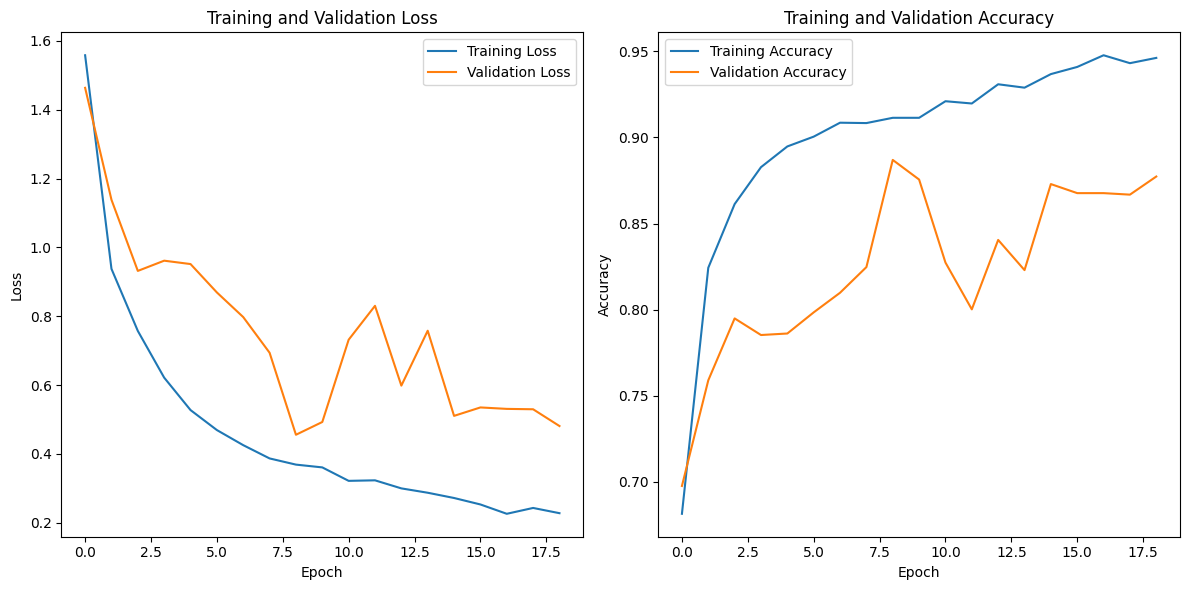

36/36 [==============================] - 3s 47ms/step


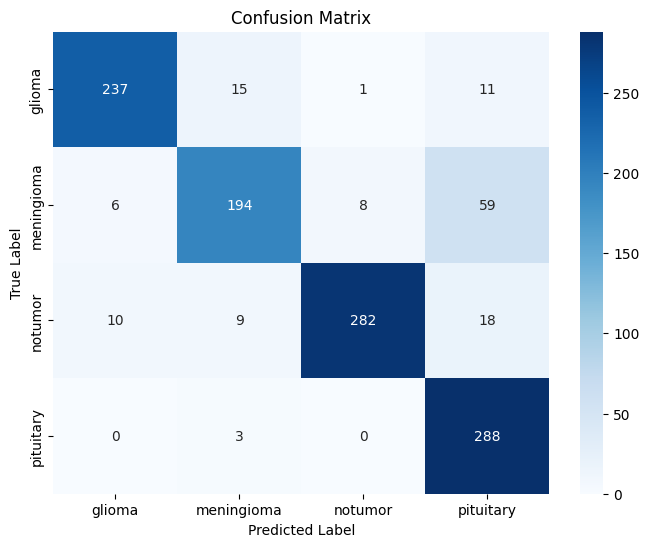

Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       264
  meningioma       0.88      0.73      0.80       267
     notumor       0.97      0.88      0.92       319
   pituitary       0.77      0.99      0.86       291

    accuracy                           0.88      1141
   macro avg       0.89      0.87      0.88      1141
weighted avg       0.89      0.88      0.88      1141



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 4)                 260       
                                                      

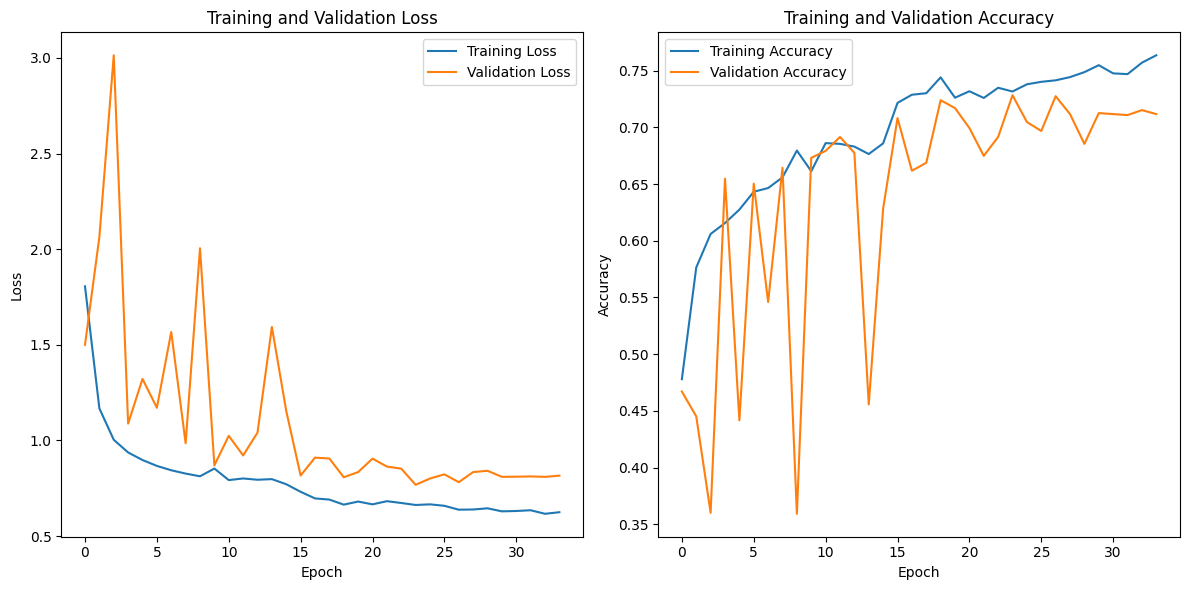

36/36 [==============================] - 2s 41ms/step


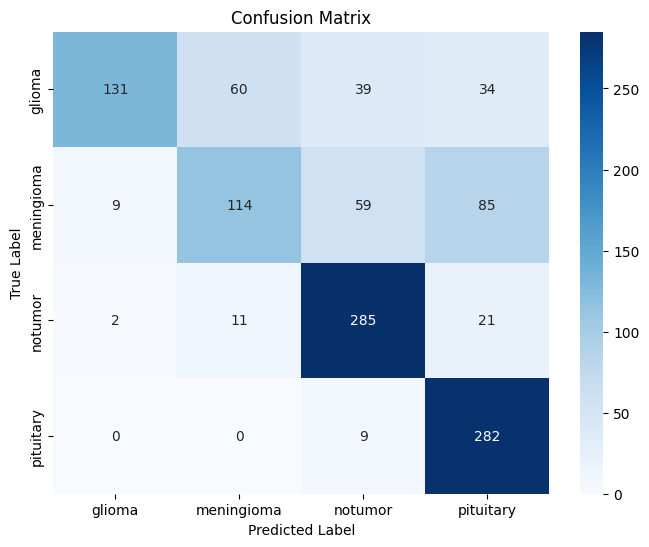

Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      0.50      0.65       264
  meningioma       0.62      0.43      0.50       267
     notumor       0.73      0.89      0.80       319
   pituitary       0.67      0.97      0.79       291

    accuracy                           0.71      1141
   macro avg       0.73      0.70      0.69      1141
weighted avg       0.73      0.71      0.69      1141



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 64)                131136    
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                      

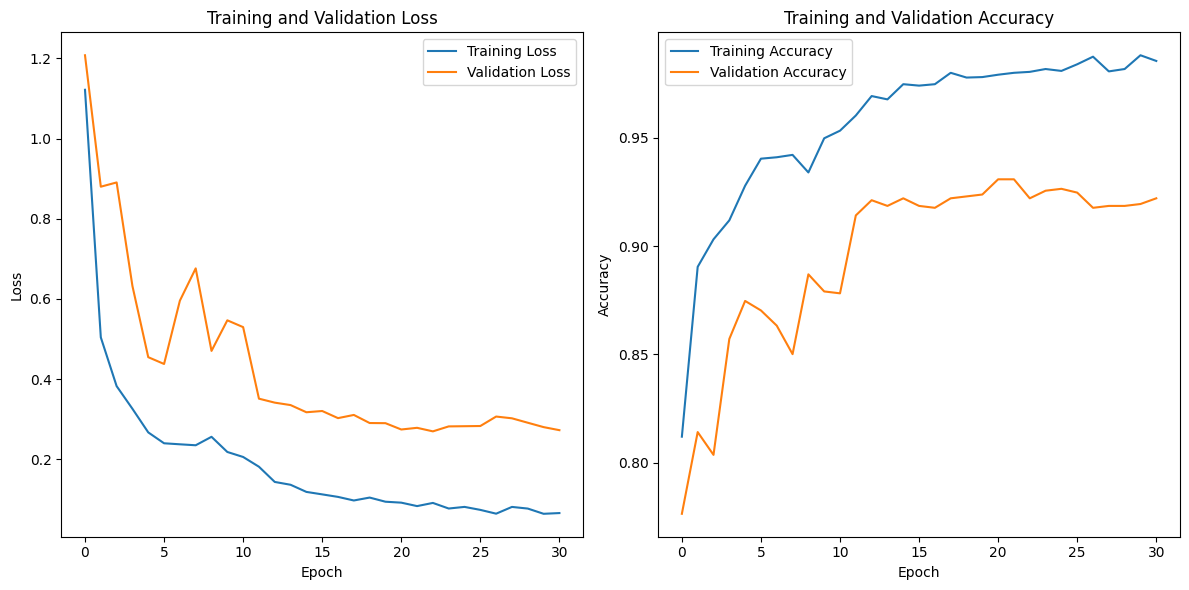

36/36 [==============================] - 2s 41ms/step


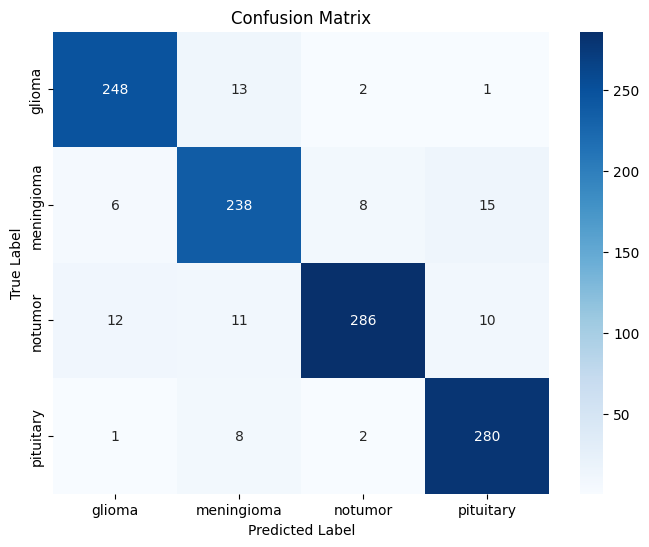

Classification Report:
               precision    recall  f1-score   support

      glioma       0.93      0.94      0.93       264
  meningioma       0.88      0.89      0.89       267
     notumor       0.96      0.90      0.93       319
   pituitary       0.92      0.96      0.94       291

    accuracy                           0.92      1141
   macro avg       0.92      0.92      0.92      1141
weighted avg       0.92      0.92      0.92      1141



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                65600     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                

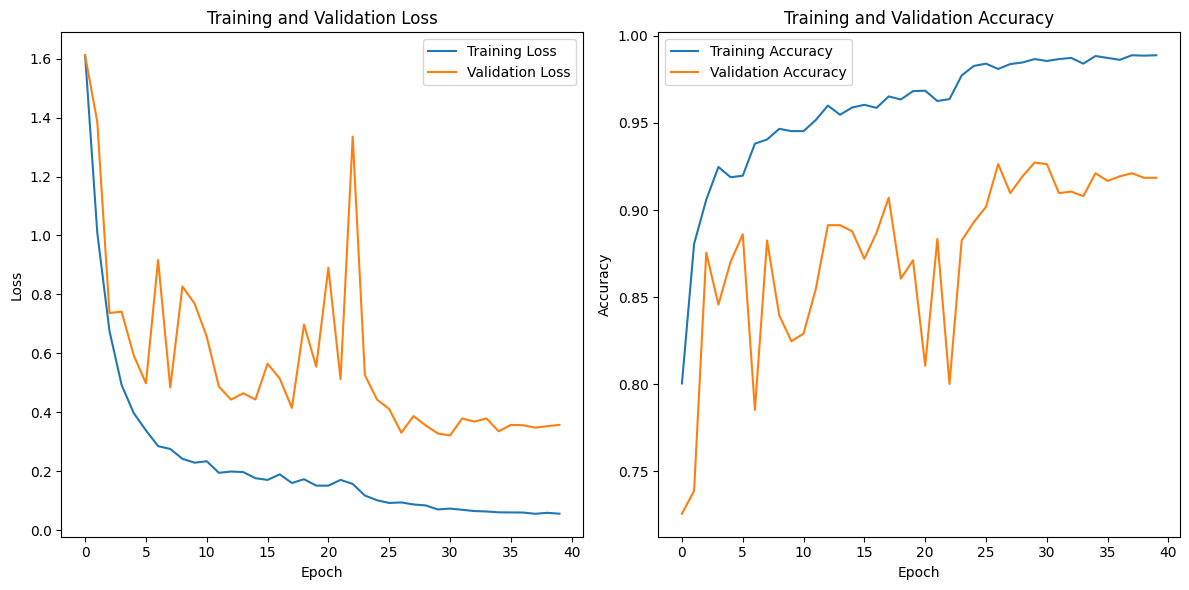

36/36 [==============================] - 2s 40ms/step


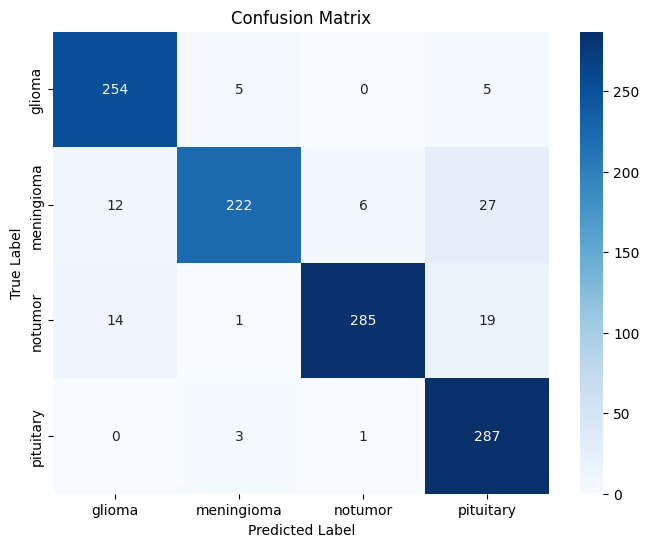

Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.96      0.93       264
  meningioma       0.96      0.83      0.89       267
     notumor       0.98      0.89      0.93       319
   pituitary       0.85      0.99      0.91       291

    accuracy                           0.92      1141
   macro avg       0.92      0.92      0.92      1141
weighted avg       0.92      0.92      0.92      1141



Found 1311 images belonging to 4 classes.


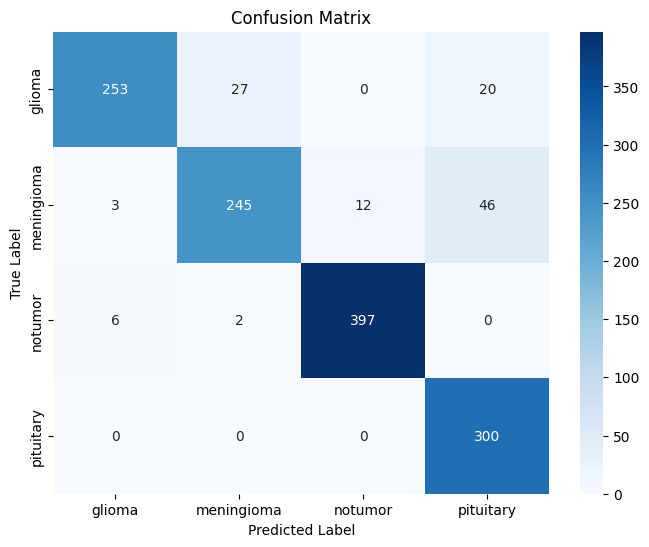

Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.84      0.90       300
  meningioma       0.89      0.80      0.84       306
     notumor       0.97      0.98      0.98       405
   pituitary       0.82      1.00      0.90       300

    accuracy                           0.91      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



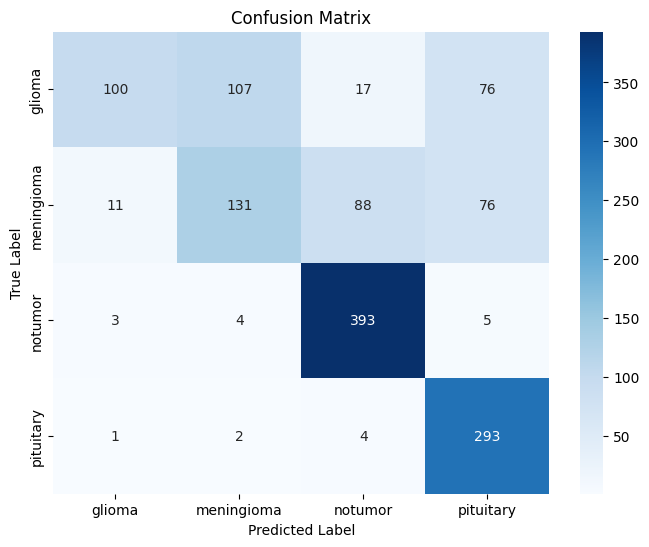

Classification Report:
               precision    recall  f1-score   support

      glioma       0.87      0.33      0.48       300
  meningioma       0.54      0.43      0.48       306
     notumor       0.78      0.97      0.87       405
   pituitary       0.65      0.98      0.78       300

    accuracy                           0.70      1311
   macro avg       0.71      0.68      0.65      1311
weighted avg       0.72      0.70      0.67      1311



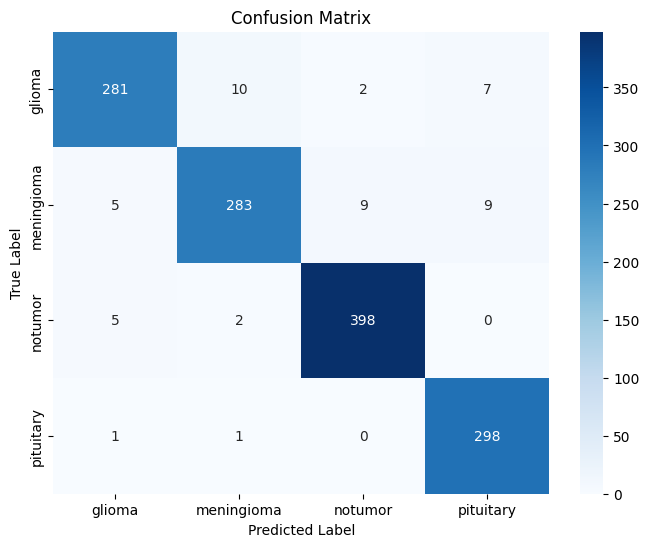

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.96      0.92      0.94       306
     notumor       0.97      0.98      0.98       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



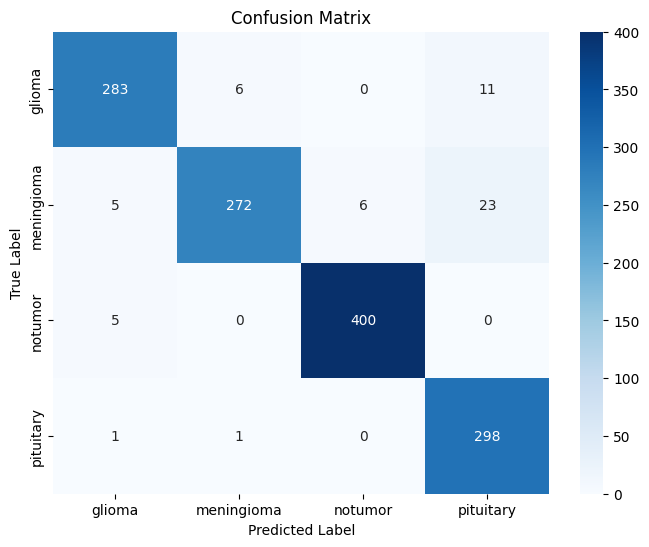

Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.97      0.89      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



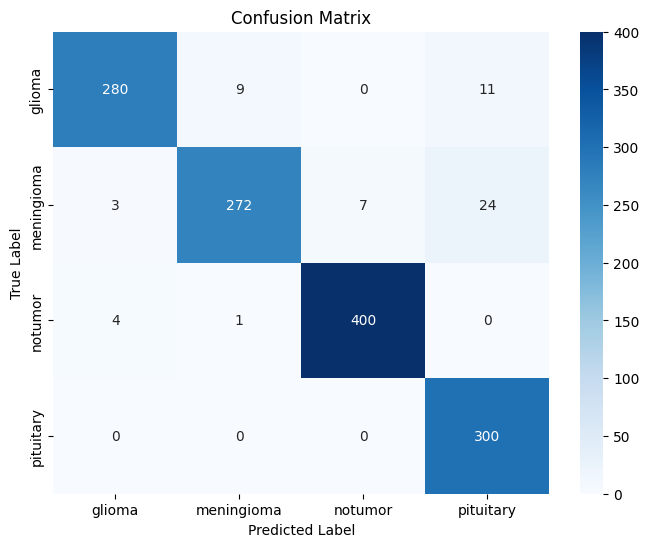

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.93      0.95       300
  meningioma       0.96      0.89      0.93       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.90      1.00      0.94       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



,Model,Accuracy,Precision,Recall,F1 Score
0,DenseNet121,0.911518,0.917107,0.911518,0.910712
1,ResNet50,0.699466,0.715142,0.699466,0.667975
2,Xception,0.961098,0.961160,0.961098,0.960906
3,MobileNet,0.955759,0.957582,0.955759,0.955630
4,Ensemble,0.954996,0.956921,0.954996,0.954830


In [32]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Paths
train_data = r"D:\data science\Brain_tumor classifiaction\tumor_Training"
test_data = r"D:\data science\Brain_tumor classifiaction\tumor_Testing"

# Parameters
image_size = (128, 128)
batch_size = 32
num_classes = 4
input_shape = (128, 128, 3)
epochs = 60
learning_rate = 0.001

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_generator = validation_datagen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
callbacks = [early_stopping, reduce_lr]

# Model creation with fine-tuning option
def create_model(base_model, fine_tune_at=None):
    base_model.trainable = True
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True
    else:
        base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Training function
def train_model(base_model, fine_tune_at=None):
    model = create_model(base_model, fine_tune_at)
    model.summary()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

# Import pretrained models
from tensorflow.keras.applications import DenseNet121, ResNet50, Xception, MobileNet

models_to_train = [
    ('DenseNet121', DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('ResNet50', ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('Xception', Xception(weights='imagenet', include_top=False, input_shape=input_shape)),
    ('MobileNet', MobileNet(weights='imagenet', include_top=False, input_shape=input_shape))
]

trained_models = []
for name, base_model in models_to_train:
    display(HTML(f'<h2>{name}</h2>'))
    display(HTML('<hr>'))
    # Fine-tune last 20 layers
    model, history = train_model(base_model, fine_tune_at=len(base_model.layers)-20)
    model.save(f'{name}_trained_model.h5')
    display(HTML('<hr>'))
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    display(HTML('<hr>'))
    # Evaluate on validation set
    y_pred = model.predict(validation_generator).argmax(axis=1)
    y_true = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())
    conf_mat = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    display(HTML('<hr>'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    display(HTML('<hr>'))
    trained_models.append((name, model))

# Test data generator with consistent image size
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Evaluate on test set
def evaluate_on_test(model, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, verbose=0)
    y_pred = y_pred_probs.argmax(axis=1)
    class_labels = list(test_generator.class_indices.keys())
    conf_mat = confusion_matrix(y_true, y_pred)
    display(HTML(f'<h2>{model_name}</h2>'))
    display(HTML('<hr>'))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    display(HTML('<hr>'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    display(HTML('<hr>'))
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

results = []
for name, model in trained_models:
    result = evaluate_on_test(model, name)
    results.append(result)

# Ensemble prediction by averaging probabilities
def ensemble_predict(models, generator):
    y_preds = [model.predict(generator, verbose=0) for _, model in models]
    avg_preds = np.mean(y_preds, axis=0)
    y_pred = avg_preds.argmax(axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    conf_mat = confusion_matrix(y_true, y_pred)
    display(HTML(f'<h2>Ensemble Model</h2>'))
    display(HTML('<hr>'))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    display(HTML('<hr>'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))
    display(HTML('<hr>'))
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {
        'Model': 'Ensemble',
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

ensemble_result = ensemble_predict(trained_models, test_generator)
results.append(ensemble_result)

results_df = pd.DataFrame(results)
display(HTML(f'<h2>Comparison between Models</h2>'))
display(HTML('<hr>'))
display(results_df)

In [4]:
from tensorflow.keras.models import load_model

model = load_model("D:\data science\Brain_tumor classifiaction\models_trained\MobileNet_trained_model.h5")
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_9   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                65600     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                

In [5]:
# Get the base MobileNet model from your Sequential model
mobilenet = model.get_layer("mobilenet_1.00_128")

# Print all layer names in MobileNet
for i, layer in enumerate(mobilenet.layers):
    print(i, layer.name, layer.output_shape)


0 input_16 [(None, 128, 128, 3)]
1 conv1 (None, 64, 64, 32)
2 conv1_bn (None, 64, 64, 32)
3 conv1_relu (None, 64, 64, 32)
4 conv_dw_1 (None, 64, 64, 32)
5 conv_dw_1_bn (None, 64, 64, 32)
6 conv_dw_1_relu (None, 64, 64, 32)
7 conv_pw_1 (None, 64, 64, 64)
8 conv_pw_1_bn (None, 64, 64, 64)
9 conv_pw_1_relu (None, 64, 64, 64)
10 conv_pad_2 (None, 65, 65, 64)
11 conv_dw_2 (None, 32, 32, 64)
12 conv_dw_2_bn (None, 32, 32, 64)
13 conv_dw_2_relu (None, 32, 32, 64)
14 conv_pw_2 (None, 32, 32, 128)
15 conv_pw_2_bn (None, 32, 32, 128)
16 conv_pw_2_relu (None, 32, 32, 128)
17 conv_dw_3 (None, 32, 32, 128)
18 conv_dw_3_bn (None, 32, 32, 128)
19 conv_dw_3_relu (None, 32, 32, 128)
20 conv_pw_3 (None, 32, 32, 128)
21 conv_pw_3_bn (None, 32, 32, 128)
22 conv_pw_3_relu (None, 32, 32, 128)
23 conv_pad_4 (None, 33, 33, 128)
24 conv_dw_4 (None, 16, 16, 128)
25 conv_dw_4_bn (None, 16, 16, 128)
26 conv_dw_4_relu (None, 16, 16, 128)
27 conv_pw_4 (None, 16, 16, 256)
28 conv_pw_4_bn (None, 16, 16, 256)
29 conv_

In [3]:
import tensorflow as tf

def check_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPUs detected: {len(gpus)}")
        for gpu in gpus:
            print(f"  - {gpu}")
    else:
        print("No GPU detected")

if __name__ == "__main__":
    check_gpu()

GPUs detected: 1
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.models.load_model)  # this should not throw an error


AttributeError: module 'tensorflow' has no attribute '__version__'

In [3]:
from tensorflow.keras.models import load_model


model = models['D:\data science\Brain_tumor classifiaction\models_trained\MobileNet_trained_model.h5']  # your loaded MobileNet model
model.summary()


ModuleNotFoundError: No module named 'tensorflow.keras'